**Призентация** - https://disk.yandex.ru/i/PH4YX5Qe7W484A

# Банки — Сегментация пользователей по потреблению

### Загрузка данных и библиотек для подготовки к исследованию

In [1]:
#загрузка необходимых для работы библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import plotly.express as px
import requests
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
from scipy.stats import spearmanr
!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

     |████████████████████████████████| 679 kB 1.0 MB/s eta 0:00:01


In [2]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [3]:
#загружаем наш файл
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

In [4]:
#взглянем на нашу таблицу
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1


Видим, что наименования столбцов необходимо привести к строчному "змеиному" регистру

In [5]:
data = data.rename (columns = {'USERID':'user_id', 'EST_SALARY':'est_salary'})
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Что косается типов данных то они на первый взгляд они соответствуют содержанию

In [7]:
data.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,"10,000.00","10,000.00","9,974.00","10,000.00","7,705.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"171,814.71",848.70,42.73,2.63,"827,794.31",1.87,0.68,0.52,"147,866.89",0.18
std,"33,708.24",65.45,12.18,1.98,"1,980,614.15",0.79,0.47,0.50,"139,388.51",0.39
min,"94,561.00",642.00,18.00,0.00,0.00,0.00,0.00,0.00,"2,546.30",0.00
25%,"142,810.25",802.00,33.00,0.00,"295,554.16",1.00,0.00,0.00,"75,251.90",0.00
50%,"172,728.00",853.00,40.00,3.00,"524,272.20",2.00,1.00,1.00,"119,658.10",0.00
75%,"201,261.75",900.00,51.00,4.00,"980,705.85",2.00,1.00,1.00,"174,500.54",0.00
max,"229,145.00","1,000.00",86.00,9.00,"119,113,552.01",5.00,1.00,1.00,"1,395,064.45",1.00


На первых взгялд каких либо выбивающихся аномалий не наблюдается. Переходим к более детальному анализу.

In [8]:
#взгялнем на пропуски
data.isnull().sum()

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

В двух столбцах есть нулевые значения, в столбце баланса нулевые значения вполне могут быть, на мой взгляд это нормально. 

А вот в столбце возраста могли не указать эти данные. То что это ошибка разработчиков таблицы исключаем (согласно встрече  с ментором). Посмотрим на них поближе.

In [9]:
print('Всего пропусков в столбце age:', data['age'].isna().sum())


Всего пропусков в столбце age: 26


In [10]:
print('В процентах от общего количества строк', (data['age'].isna().sum())*100/len(data))

В процентах от общего количества строк 0.26


In [11]:
data[data['age'].isna()].describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,26.00,26.00,0.00,26.00,10.00,26.00,26.00,26.00,26.00,26.00
mean,"194,637.50",855.15,NaN,1.38,"1,250,033.57",1.35,0.77,0.77,"178,585.20",0.04
std,"31,310.55",83.42,NaN,1.96,"2,265,234.84",0.56,0.43,0.43,"175,135.55",0.20
min,"127,440.00",663.00,NaN,0.00,"171,510.23",1.00,0.00,0.00,"55,073.63",0.00
25%,"185,142.00",827.50,NaN,0.00,"252,326.77",1.00,1.00,1.00,"77,807.76",0.00
50%,"208,447.00",888.50,NaN,0.00,"417,361.11",1.00,1.00,1.00,"142,598.86",0.00
75%,"219,224.25",919.25,NaN,3.00,"1,039,439.01",2.00,1.00,1.00,"176,991.69",0.00
max,"228,075.00",942.00,NaN,5.00,"7,601,719.20",3.00,1.00,1.00,"922,080.25",1.00


В столбце с данными о возрасте видим пропуски, но остальные данные в тех же строках заполнены. Думаю, что заполнять пропуски средним значением будет не совсем корректно для дальнейшего анализа данных, а так как процент пропусков относительно всего датафрейма маленький, принимаю решение их просто удалить.

In [12]:
data = data.dropna(subset=['age'])

Перейдем теперь к пропускам в балансе

In [13]:
print('Всего пропусков в столбце balance:', data['balance'].isna().sum())


Всего пропусков в столбце balance: 2279


In [14]:
print('В процентах от общего количества строк', (data['balance'].isna().sum())*100/len(data))

В процентах от общего количества строк 22.849408462001204


In [15]:
data[data['balance'].isna()].describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,"2,279.00","2,279.00","2,279.00","2,279.00",0.00,"2,279.00","2,279.00","2,279.00","2,279.00","2,279.00"
mean,"171,904.89",865.36,42.09,0.05,NaN,1.16,0.82,0.55,"226,345.42",0.01
std,"33,303.22",89.55,11.94,0.23,NaN,0.40,0.39,0.50,"199,825.59",0.08
min,"114,182.00",642.00,18.00,0.00,NaN,0.00,0.00,0.00,"20,274.03",0.00
25%,"142,992.50",871.00,33.00,0.00,NaN,1.00,1.00,0.00,"120,217.39",0.00
50%,"172,304.00",903.00,40.00,0.00,NaN,1.00,1.00,1.00,"174,347.87",0.00
75%,"201,257.00",922.00,49.00,0.00,NaN,1.00,1.00,1.00,"240,372.78",0.00
max,"229,145.00",990.00,86.00,3.00,NaN,3.00,1.00,1.00,"1,333,687.36",1.00


Видим, что у пользователей с неуказанным балансом средний показатель оценки собственности клиента стремится к нулю, но при этом, заработная плата в среднем выше, чем у пользователей всего остального датасета, плюс прописков в балансе, давольно много, почти 23%. 

Пока мы не можем определить природу пропусков, принимаем решение оставить их как есть.

In [16]:
data1 = data.dropna(subset=['balance'])

In [17]:
data1.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,"7,695.00","7,695.00","7,695.00","7,695.00","7,695.00","7,695.00","7,695.00","7,695.00","7,695.00","7,695.00"
mean,"171,710.89",843.74,42.92,3.39,"827,245.59",2.08,0.64,0.52,"124,520.39",0.23
std,"33,812.86",55.34,12.24,1.58,"1,980,327.41",0.76,0.48,0.50,"104,667.11",0.42
min,"94,561.00",689.00,18.00,0.00,0.00,1.00,0.00,0.00,"2,546.30",0.00
25%,"142,638.00",801.00,33.00,2.00,"295,698.71",2.00,0.00,0.00,"67,556.98",0.00
50%,"172,710.00",840.00,40.00,4.00,"524,295.33",2.00,1.00,1.00,"106,250.18",0.00
75%,"201,145.50",882.00,52.00,5.00,"980,051.21",2.00,1.00,1.00,"155,144.60",0.00
max,"229,136.00","1,000.00",86.00,9.00,"119,113,552.01",5.00,1.00,1.00,"1,395,064.45",1.00


In [18]:
data.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,"9,974.00","9,974.00","9,974.00","9,974.00","7,695.00","9,974.00","9,974.00","9,974.00","9,974.00","9,974.00"
mean,"171,755.22",848.68,42.73,2.63,"827,245.59",1.87,0.68,0.52,"147,786.81",0.18
std,"33,695.53",65.40,12.18,1.98,"1,980,327.41",0.79,0.47,0.50,"139,285.51",0.39
min,"94,561.00",642.00,18.00,0.00,0.00,0.00,0.00,0.00,"2,546.30",0.00
25%,"142,760.00",802.00,33.00,0.00,"295,698.71",1.00,0.00,0.00,"75,251.66",0.00
50%,"172,643.00",853.00,40.00,3.00,"524,295.33",2.00,1.00,1.00,"119,626.79",0.00
75%,"201,163.75",900.00,51.00,4.00,"980,051.21",2.00,1.00,1.00,"174,499.81",0.00
max,"229,145.00","1,000.00",86.00,9.00,"119,113,552.01",5.00,1.00,1.00,"1,395,064.45",1.00


Необязательно делать именно так <code> .apply(lambda gr: gr.describe().T[['mean', '50%']].T) </code>:
<ul>
    <li> можно просто describe
        <li> или вообще только среднее с медианой
        </ul> 

Или есть обратный способ: показать долю пропусков в разрезе других признаков: из сравнения выше заметно, что существенные различия наблюдаются по score(различаются и средние и медианы), по equity\products - можно их проверить дополнительно


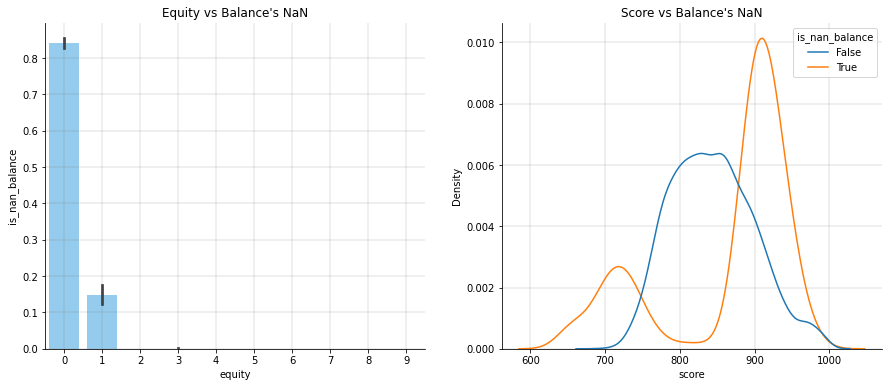

In [20]:
#CODE REVIEW
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
axes = axes.flatten()

ax = axes[0]
sns.despine(left=False, ax=ax)
sns.barplot(data=data.assign(is_nan_balance=lambda row: row['balance'].isna()),
           x='equity', y='is_nan_balance', ax=ax, color='lightskyblue')
ax.grid( color='grey', lw=0.25)
ax.set_title("Equity vs Balance's NaN")

ax = axes[1]
sns.despine(left=False, ax=ax)
sns.kdeplot(data=data.assign(is_nan_balance=lambda row: row['balance'].isna()),
           x='score', hue='is_nan_balance', ax=ax, common_norm=False)
ax.grid( color='grey', lw=0.25)
ax.set_title("Score vs Balance's NaN")
plt.show();


In [21]:
#Теперь посмотрим на дубликаты
data.duplicated().sum()

0

Явных дубликатов не найдено.

In [22]:
# помщем дубликаты в столбце с идентификатором пользователя
print ("итого дубликатов в столбце user_id:", data.duplicated(subset=["user_id"]).sum())

итого дубликатов в столбце user_id: 50


In [23]:
print ("В процентах от общего количества строк:", data.duplicated(subset=["user_id"]).sum()*100/len(data))

В процентах от общего количества строк: 0.5013033888109084


In [24]:
data[data.duplicated(['user_id', 'city', 'gender', 'age'])]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


У нас есть 50 одинаковых user_id, но при этом нет строк, где были бы одинаковыми user_id, город, пол и возраст клиента.

In [25]:
data[data.duplicated(['user_id', 'city', 'gender'])]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


Нет строк, где были бы одинаковыми user_id, город и пол клиента.

In [26]:
data[data.duplicated(['user_id', 'city', 'age'])]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


Нет строк, где были бы одинаковыми user_id, город и возраст клиента.

In [27]:
data[data.duplicated(['user_id', 'gender', 'age'])]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
5197,155765,923.00,Рыбинск,М,30.00,0,NaN,1,1,1,"120,296.60",0
8497,227795,839.00,Ярославль,М,34.00,2,"326,593.14",2,1,0,"103,314.92",0


А вот тут есть строки, где задублировались user_id, пол и возраст.

In [28]:
data.loc[((data['user_id'] == 155765) & (data['gender'] == 'М') & (data['age'] == 30.0))]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3274,155765,863.00,Ярославль,М,30.00,5,"1,036,114.50",5,1,1,"150,744.50",1
5197,155765,923.00,Рыбинск,М,30.00,0,NaN,1,1,1,"120,296.60",0


In [29]:
data.loc[((data['user_id'] == 227795) & (data['gender'] == 'М') & (data['age'] == 34.0))]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8205,227795,840.00,Рыбинск,М,34.00,2,"350,768.03",1,1,0,"102,036.14",1
8497,227795,839.00,Ярославль,М,34.00,2,"326,593.14",2,1,0,"103,314.92",0


Видно, что эти клиенты зарегестрированы сразу в двух городах и при этом у них разные значения оттока. Так как у нас всего 50 дубликаатов по user_id, а это всего 0,5% от всех данных, то принимаю решение их удалить, чтоб дальше не запутаться.

In [30]:
data = data.drop_duplicates (subset=['user_id'])

In [31]:
data['user_id'].duplicated().sum()

0

In [32]:
#Взгялнем на то, что у нас получилось
data.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,"9,924.00","9,924.00","9,924.00","9,924.00","7,664.00","9,924.00","9,924.00","9,924.00","9,924.00","9,924.00"
mean,"171,737.16",848.73,42.73,2.63,"828,206.27",1.87,0.68,0.52,"147,880.18",0.18
std,"33,697.42",65.40,12.18,1.98,"1,984,121.61",0.79,0.47,0.50,"139,358.30",0.39
min,"94,561.00",642.00,18.00,0.00,0.00,0.00,0.00,0.00,"2,546.30",0.00
25%,"142,725.00",802.00,33.00,0.00,"295,526.57",1.00,0.00,0.00,"75,252.18",0.00
50%,"172,643.00",853.00,40.00,3.00,"524,927.74",2.00,1.00,1.00,"119,715.39",0.00
75%,"201,159.25",900.00,51.00,4.00,"980,753.67",2.00,1.00,1.00,"174,666.93",0.00
max,"229,145.00","1,000.00",86.00,9.00,"119,113,552.01",5.00,1.00,1.00,"1,395,064.45",1.00


Только сейчас увидел, что есть клиенты у которых 0 банковских продуктов но при этом они являются клиентами банка что не совсем логично. Посмотрим, сколько таких клиентов.

In [33]:
data[data['products']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.00,Рыбинск,Ж,79.00,3,NaN,0,0,0,"25,063.96",1


Видим одного клиента. Так как он один, возможно это ошибочная строка. Хоть столбец churn говорит нам о том что клиент вроде бы ушел, возможно даже закрыл все имеющиеся у него банковские продукты, не был активен, все же он один, подобных ему клиентов не наблюдается. Принимаю решение удалить эту строку. 

In [34]:
data = data[data['products']!=0]

In [35]:
data.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1
5,202305,856.00,Рыбинск,М,56.00,4,"863,687.24",3,1,0,"156,619.80",0
6,177259,807.00,Ярославль,Ж,39.00,3,"405,042.44",3,0,1,"103,838.32",0
7,218868,825.00,Ярославль,Ж,38.00,4,"458,145.40",2,1,1,"68,085.48",0
8,211686,923.00,Ярославль,М,54.00,5,"1,206,337.87",2,1,0,"155,371.79",0
9,133130,906.00,Ярославль,Ж,67.00,0,NaN,1,0,1,"238,055.53",0


Переходим к котигоризации.

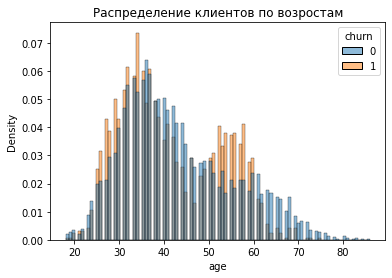

In [36]:
#поделим клиентов на категории по возрасту.
sns.histplot(data=data, hue='churn', x='age', bins=100, stat='density', common_norm=False)
plt.title('Распределение клиентов по возростам')
plt.show()

По графику видим, что плотность оттока клиентов растет примерно до 35 лет, затем падает до возраста клиентов примерно в 47 лет и снова начинает расти до 60 лет, далее идет на спад. Саммые отточные группы по возрасту это: от 24-25 до 34-35 лет и от 50 до 60 лет.

In [37]:
# Создадим функцию, которая поделит наших клиентов на группы по возрасту
def age_group(age):
    if age <= 25:
        return '18-25'
    if age >25 and age <= 35:
        return '26-35'
    if age >35 and age <= 49:
        return '36-49'
    if age >49 and age <= 60:
        return '50-60'
    return '60+' 

In [38]:
# применим функцию age_group и добавим новый столбец
data['age_group'] = data['age'].apply(age_group)

In [39]:
data['score'].describe()

count   9,923.00
mean      848.72
std        65.39
min       642.00
25%       802.00
50%       853.00
75%       900.00
max     1,000.00
Name: score, dtype: float64

In [40]:
def score_group(score):
    if score <= 650:
        return '0-650'
    if score >650 and score <= 750:
        return '650-750'
    if score >750 and score <= 850:
        return '750-850'
    if score >850 and score <= 950:
        return '850-950'
    return '+950' 

In [41]:
data['score_group'] = data['score'].apply(score_group)
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_group,score_group
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1,18-25,750-850
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0,36-49,850-950
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0,26-35,850-950
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1,50-60,850-950
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1,26-35,650-750


**Вывод:** мы провелми предобработку данных: 
* переименовали столбцы; 
* удалили пропуски в возрасте; 
* проанализировали часть датасета, содержащую пропуски в столбце с балансом, решили оставить как есть; 
* сделали проверку на явные и неявные дубликаты, от дубликатов в столбце с идентификатором пользователя решили избавиться;
* провели проверку на выбросы; 
* закодировали столбец пола;
* сделали категоризацию клиентов по возрасту; 

In [42]:
data.to_csv('my_data1.csv', index=True)

In [43]:
#сделаем столбец с полом в бинарном виде
data['gender'] = data['gender'].str.replace("М", '1')
data['gender'] = data['gender'].str.replace("Ж", '0')
data['gender'] = data['gender'].astype('int')

### Исследовательский анализ данных.

Посмотрим на распределения клиентов по разным признакам.

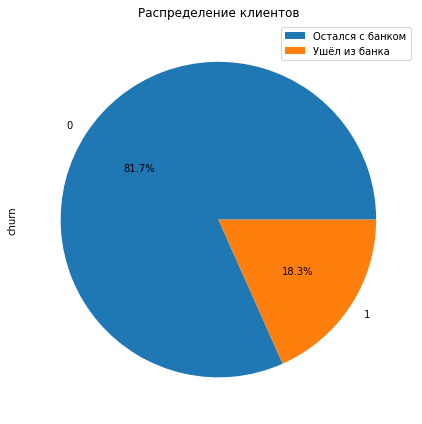

In [44]:
#Посмотрим на распределение клиентов относительно того, ушли они из банка или нет
data['churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8,6))
plt.legend(['Остался с банком', 'Ушёл из банка'])
plt.title('Распределение клиентов')
plt.tight_layout()

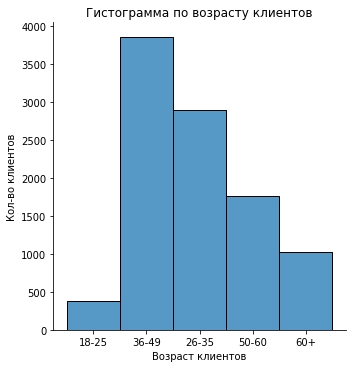

In [45]:
# Построим гистограмму по возпрасту клиентов
sns.displot(data['age_group'], kde=False, bins=4)
plt.title('Гистограмма по возрасту клиентов')
plt.xlabel('Возраст клиентов')
_ = plt.ylabel('Кол-во клиентов')

Видим, что большая часть клиентов в возрасте от 36 до 49 лет.

,sum,count,percent
age_group,,,
50-60,468,1764,26.53
26-35,634,2901,21.85
18-25,62,375,16.53
36-49,588,3859,15.24
60+,66,1024,6.45


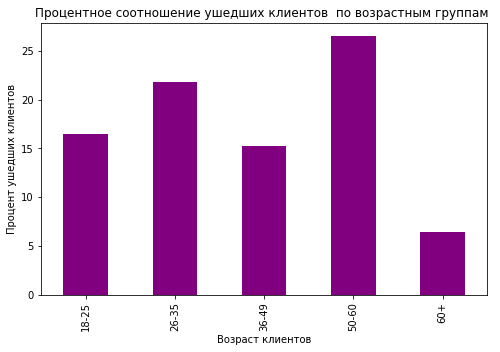

In [46]:
# Рассчитаем процентное соотношение ушедших клиентов  по возрастным группам 
data_age_churn = data.pivot_table(index = 'age_group', values = 'churn', aggfunc =['sum', 'count'])
data_age_churn.columns = data_age_churn.columns.droplevel(level=1)
data_age_churn['percent'] = round(data_age_churn['sum']/data_age_churn['count']*100, 2)

# Построим столбчатую диаграмму:
data_age_churn['percent'].plot(
    kind='bar', title = 'Процентное соотношение ушедших клиентов  по возрастным группам ',
    xlabel = 'Возраст клиентов', ylabel = 'Процент ушедших клиентов', figsize = (8,5), 
    color = 'purple')
data_age_churn.sort_values(by='percent', ascending=False)

Самый большой процент ушедших клиентов приходится ена группу 50-60 лет (26%), на втором месте 26-35 лет (21%), меньше всего уходят клиенты в возрасте 60+ лет (менее 7%).

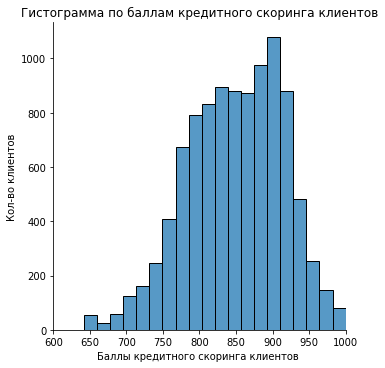

In [47]:
# Построим гистограмму по  баллам кредитного скоринга клиентов
sns.displot(data['score'], kde=False, bins=20)
plt.xlim(600, 1000)
plt.title('Гистограмма по баллам кредитного скоринга клиентов')
plt.xlabel('Баллы кредитного скоринга клиентов ')
_ = plt.ylabel('Кол-во клиентов')

Большая часть клиентов имеет от 780 до 920 баллов кредитного скоринга

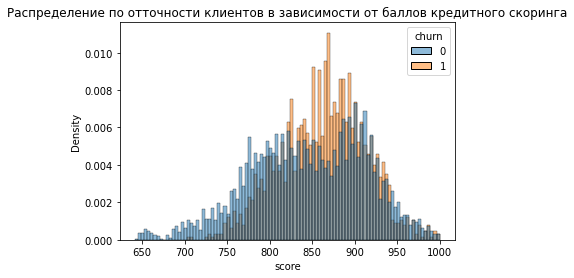

In [48]:
sns.histplot(data=data, hue='churn', x='score', bins=100, stat='density', common_norm=False)
plt.title('Распределение по отточности клиентов в зависимости от баллов кредитного скоринга')
plt.show()

В разрезе баллов кредитного скорринга большая часть клиентов уходит в диапазоне от 825 до 900 баллов.

Text(0.5, 1.0, 'Гистограмма распределения среднего значения оттока клиентов в зависимости от пола')

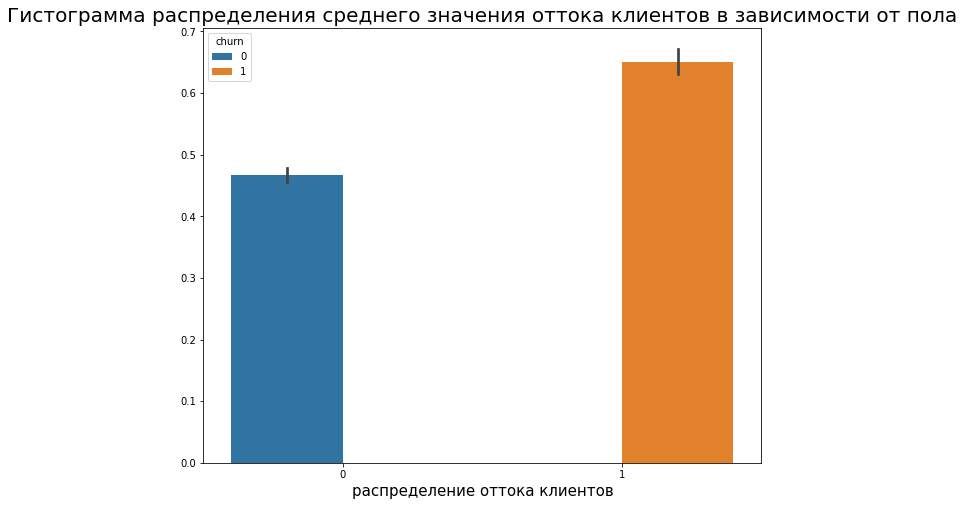

In [49]:
plt.figure(figsize=(10,8))
sns.barplot(y='gender', x='churn', hue='churn', data=data, estimator=np.mean)
plt.ylabel('')
plt.xlabel(f"распределение оттока клиентов", fontsize = 15)
plt.title(f'Гистограмма распределения среднего значения оттока клиентов в зависимости от пола', fontsize=20)

Мужчины уходят из банка чаще чем женщины.

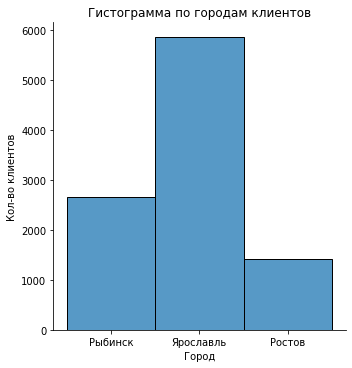

In [50]:
sns.displot(data['city'], kde=False, bins=50)
plt.title('Гистограмма по городам клиентов')
plt.xlabel('Город')
_ = plt.ylabel('Кол-во клиентов')

Большая часть клиентов сосредоточена в Ярославле.

Text(0.5, 1.0, 'Гистограмма распределения по отточности клиентов в зависимости от города')

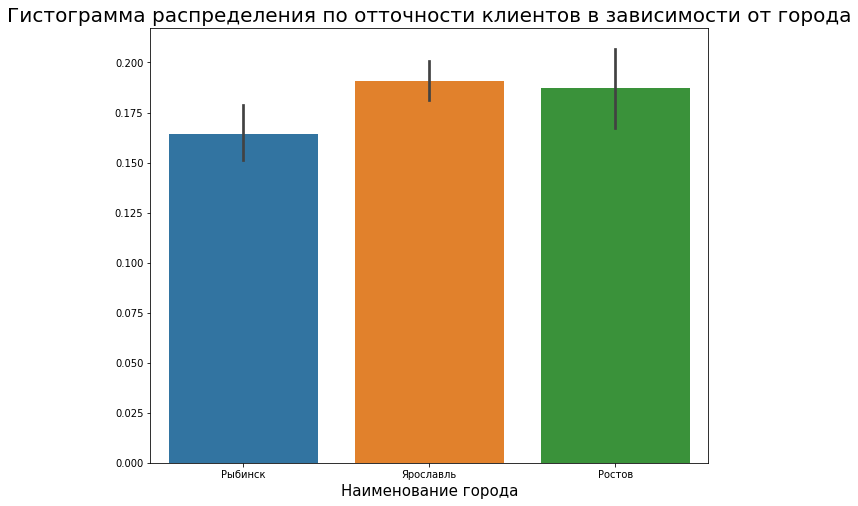

In [51]:
plt.figure(figsize=(10,8))
sns.barplot(y='churn', x='city', data=data, estimator=np.mean)
plt.ylabel('')
plt.xlabel(f"Наименование города", fontsize = 15)
plt.title(f'Гистограмма распределения по отточности клиентов в зависимости от города', fontsize=20)

В Ярославле клиентыв уходят чаще, чем остаются, в Рыбинске наоборот, большая часть клиентов остается в банке, а в Ростове показатели примерно одинаковы.

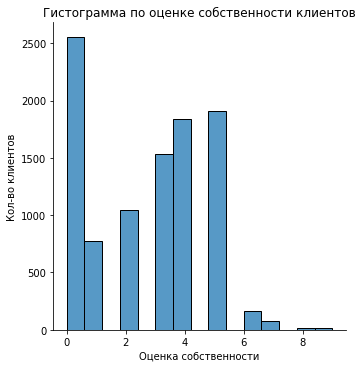

In [52]:
# Построим гистограмму по оценке собственности клиентов
sns.displot(data['equity'], kde=False, bins=15)
plt.title('Гистограмма по оценке собственности клиентов')
plt.xlabel('Оценка собственности')
_ = plt.ylabel('Кол-во клиентов')

Большая часть клиентов багка имеет нулевую оценку собственности, на втором и третьем месте идут оценки в 4 и 5 баллов соответственно.

Text(0.5, 1.0, 'Распределение по отточности  клиентов в зависимостиот отценки собственности')

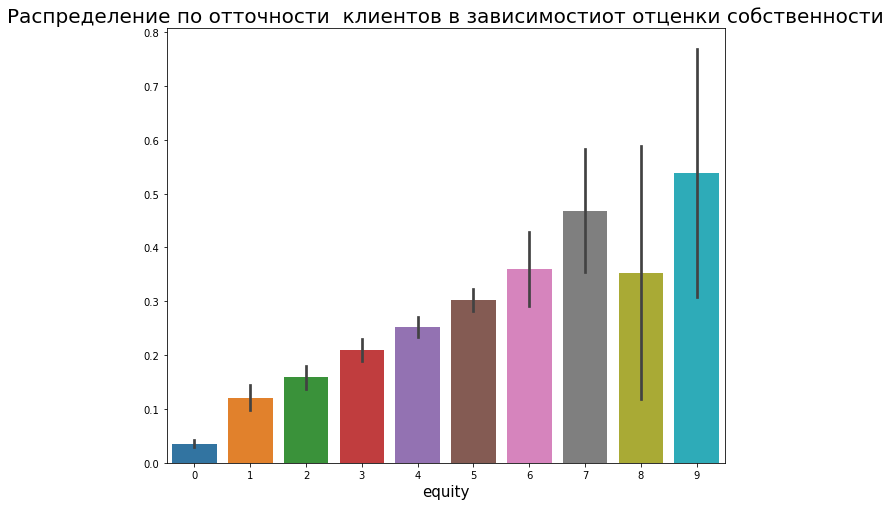

In [53]:
plt.figure(figsize=(10,8))
sns.barplot(y='churn', x='equity', data=data, estimator=np.mean)
plt.ylabel('')
plt.xlabel(f"equity", fontsize = 15)
plt.title(f'Распределение по отточности  клиентов в зависимостиот отценки собственности', fontsize=20)

По графику мы видим явный рост оттока клиентов, начиная с оценки собственности в три балла и более, а с пяти баллов плотность отточных клиентов начинает превышать плотность остающихся.

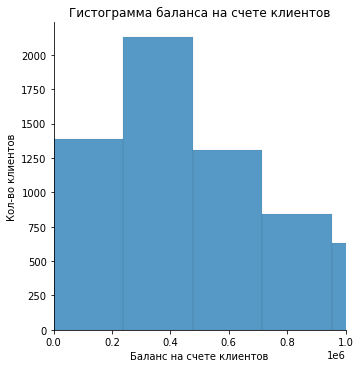

In [54]:
# Построим гистограмму баланса на счете клиентов
sns.displot(data['balance'], kde=False, bins=500)
plt.xlim(0, 1000000)
plt.title('Гистограмма баланса на счете клиентов')
plt.xlabel('Баланс на счете клиентов')
_ = plt.ylabel('Кол-во клиентов')

Большая часть клиентов емеет на своем счете от 220 000 у.е. до 440 000 у.е.

upper_thr: 2008594.3162499997


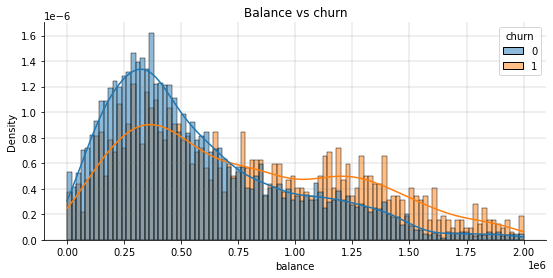

In [55]:
# Находим примерную границу аномалий СВЕРХУ
q25, q75 = np.nanpercentile(data['balance'], [25, 75])
iqr = np.diff([q25, q75])

k = 1.5 # коэффицент можно выбрать любой, по умолчанию 
upper_thr = (q75 + k*iqr)[0]

print(f"upper_thr: {upper_thr}")

fig, ax = plt.subplots(figsize=(9, 4))

sns.despine(left=False, ax=ax)
sns.histplot(data=data.loc[data['balance']<upper_thr], hue='churn', bins=100, 
             x='balance', stat='density', common_norm=False, kde=True, ax=ax)
ax.grid( color='grey', lw=0.25)
ax.set_title("Balance vs churn");


Видим, что клиенты со счетом от 700 000 у.е и более уходят из банка охотнее, чем остаются, а вот клиенты с небольшим счетом наоборот, в основном остаются.

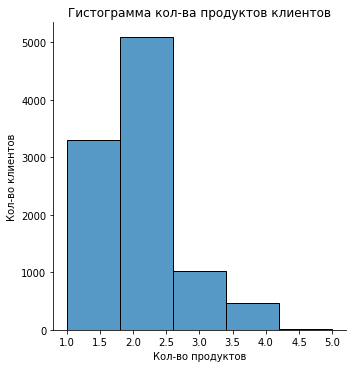

In [58]:
# Построим гистограмму кол-ва продуктов клиентов
sns.displot(data['products'], kde=False, bins=5)
#plt.xlim(0, 1000000)
plt.title('Гистограмма кол-ва продуктов клиентов')
plt.xlabel('Кол-во продуктов')
_ = plt.ylabel('Кол-во клиентов')

У большинства клиентов банка 1-2 продукта.

Text(0.5, 1.0, 'Распределение по отточности  клиентов в зависимости от кол-ва продуктов')

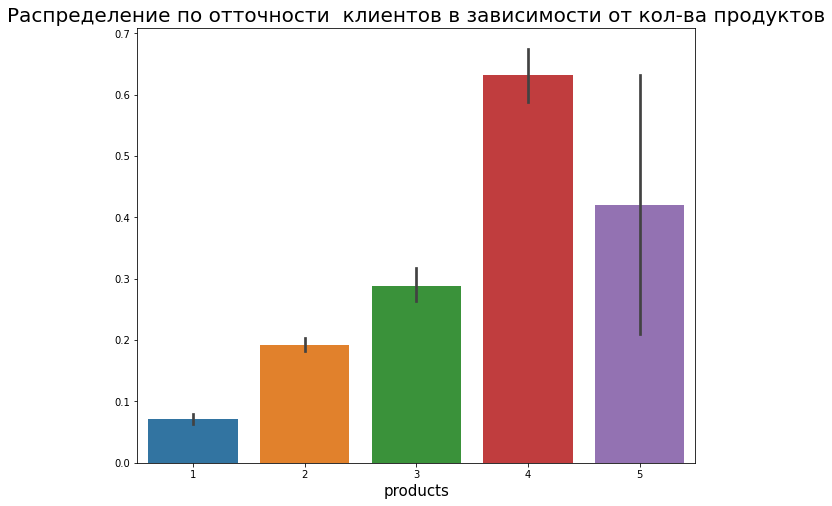

In [59]:
plt.figure(figsize=(10,8))
sns.barplot(y='churn', x='products', data=data, estimator=np.mean)
plt.ylabel('')
plt.xlabel(f"products", fontsize = 15)
plt.title(f'Распределение по отточности  клиентов в зависимости от кол-ва продуктов', fontsize=20)

При этом мы видим необычное явление -  чем больше продуктов у клиентов, тем больше плотность оттока.

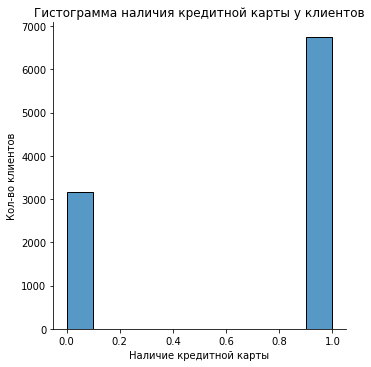

In [60]:
# Построим гистограмму наличия кредитной карты у клиентов
sns.displot(data['credit_card'], kde=False, bins=10)
#plt.xlim(0, 1000000)
plt.title('Гистограмма наличия кредитной карты у клиентов')
plt.xlabel('Наличие кредитной карты')
_ = plt.ylabel('Кол-во клиентов')

Клиентов с кредитной картой примерно в два раза больше, чем клиентов без нее.

Text(0.5, 1.0, 'Распределение по отточности  клиентов в зависимости от наличия кредитной карты')

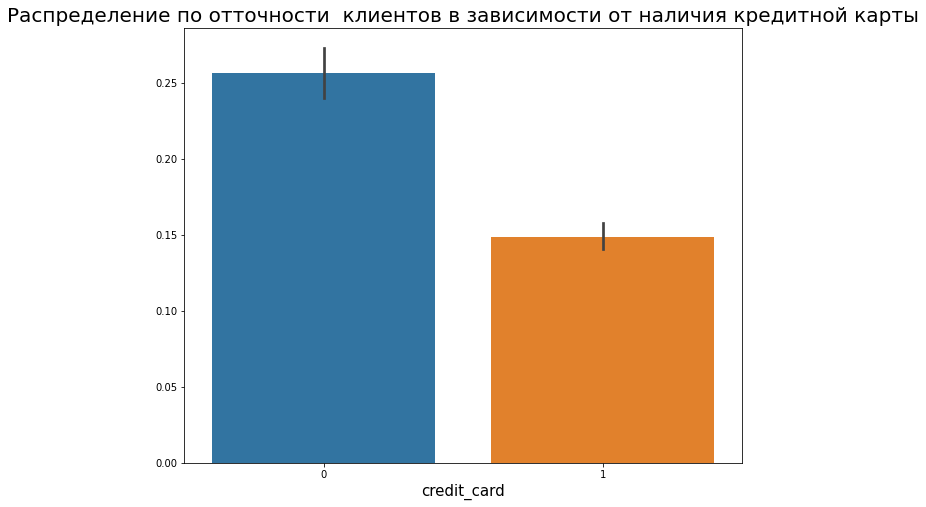

In [61]:
plt.figure(figsize=(10,8))
sns.barplot(y='churn', x='credit_card', data=data, estimator=np.mean)
plt.ylabel('')
plt.xlabel(f"credit_card", fontsize = 15)
plt.title(f'Распределение по отточности  клиентов в зависимости от наличия кредитной карты', fontsize=20)

Клиенты без кредитной карты уходят чаще чем остаются, а клиенты с кредитной картой наоборот, уходят реже.

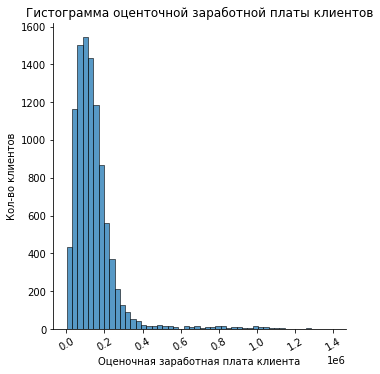

In [62]:
# Построим гистограмму зарплаты клиентов
sns.displot(data['est_salary'], kde=False, bins=50)
plt.title('Гистограмма оценточной заработной платы клиентов')
plt.xlabel('Оценочная заработная плата клиента')
plt.xticks(rotation=30)
_ = plt.ylabel('Кол-во клиентов')

In [63]:
data['est_salary'].describe()

count       9,923.00
mean      147,892.55
std       139,359.86
min         2,546.30
25%        75,255.86
50%       119,719.33
75%       174,673.28
max     1,395,064.45
Name: est_salary, dtype: float64

Медианная оценочная заработная плата клиента примерно равна 150 000 у.е., в целом, основная часть клиентов имеет зарплаты от 75 000 у.е до 175 000 у.е.

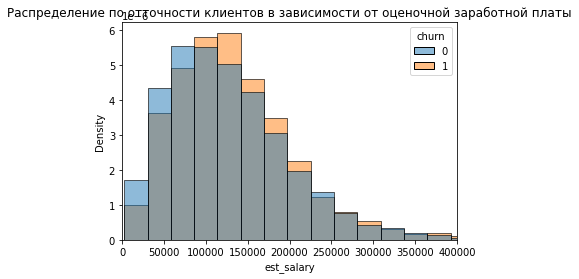

In [64]:
sns.histplot(data=data, hue='churn', x='est_salary', bins=50, stat='density', common_norm=False)
plt.xlim(0, 400000)
plt.title('Распределение по отточности клиентов в зависимости от оценочной заработной платы')
plt.show()

Из распределения видно, что, начиная от зарплаты в 100 000 у.е. и более, все больше клиентов уходят из банка.

**Портрет отточных клиентов**

Мы определили применые границы показателей, при которых клиенты уходят из банка. Объединим их в один портрет отточного пользователя:

* score — баллы кредитного скоринга: в диапазоне от 800 и более
* city — город: Ярославль
* gender — пол: мужской
* age_group — возрастная группа: 50-60
* equity — приблизительная оценка собственности клиента: 5 и более
* balance — баланс на счёте: 700 000 у.е. и более
* products — количество продуктов, которыми пользуется клиент: от 3 продуктов
* credit_card — есть ли кредитная карта: нет
* est_salary — оценочная заработная плата клиента: от 100 000 у.е.

**Корреляционный анализ.**

In [65]:
# Удалим столбец user_id, чтобы он не попал в корреляцию
data_corr = data.drop(columns='user_id') 

Отобразим тепловую гистограмму с распределением корреляции Phik:

interval columns not set, guessing: ['score', 'gender', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn']


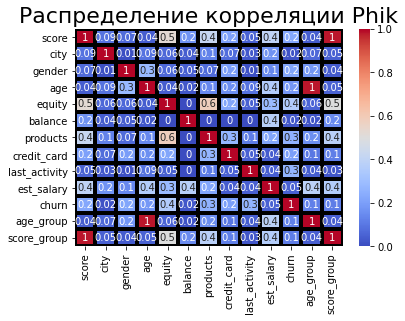

In [66]:
# Выведем тепловую гистограмму с распределением корреляции Phik:
phik = data_corr.phik_matrix()
sns.heatmap(phik, annot=True, fmt='.0g', linewidths=3, linecolor='black', cmap= 'coolwarm')
sns.set(rc = {'figure.figsize':(20,20)})
plt.title('Распределение корреляции Phik', fontsize=22)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.show()

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid orange 2px; padding: 20px"> <b>Что можно улучшить</b><br>Для упрощения визуализации и улучшения представления данных, рекомендую сменить цветовую палитру. Коэффициент корреляции лежит в диапазоне от -1 до 1, отрицательные и положительные числа хорошо ассоциируются с холодными и теплыми цветами - то есть при чтении визуализации не будет необходимости всматриваться в конкретные цифры, потому что это привычно (холод на улице, снег обычно представляются синеми\голубыми цветами, а тепло\жара красными оранжевыми). Попробуй, может получится что-то интересное.<br><img src=http://storage.yandexcloud.net/public-bucket-6/cmaps.png></div> 

По корреляционной таблице можем увидеть, что параметр churn имеет зависимость от таких параметров:

* gender (пол)
* last_activity (был ли клиент активен последнее время)
* credit_card(наличие кредитной карты)
* products (количество продуктов, которыми пользуется клиент)
* equity (приблизительная оценка собственности клиента)
* score (баллы кредитного скоринга)
* age (возраст клиента)

,sum,count,percent
gender,,,
1,1183,4971,23.80
0,635,4952,12.82


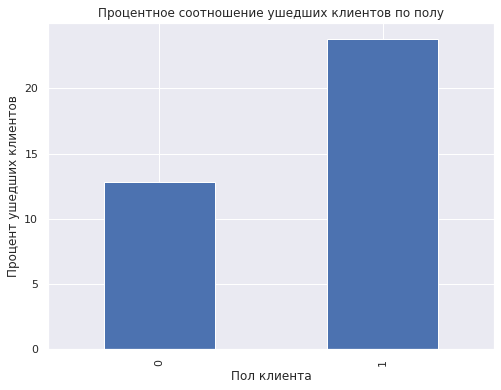

In [67]:
# Рассчитаем процентное соотношение ушедших клиентов по полу
data_gender_churn = data.pivot_table (index = 'gender', values = 'churn', aggfunc = ['sum', 'count'])
data_gender_churn.columns = data_gender_churn.columns.droplevel(level=1)
data_gender_churn ['percent'] = round(data_gender_churn['sum']/data_gender_churn['count']*100, 2)

data_gender_churn['percent'].plot(
    kind='bar', title = 'Процентное соотношение ушедших клиентов по полу', figsize = (8,6),
    xlabel = 'Пол клиента', ylabel = 'Процент ушедших клиентов');

data_gender_churn.sort_values(by='percent', ascending=False)

Как ранее было замечено, мужчины уходят сильно чаще женщин.

,sum,count,percent
last_activity,,,
1,1277,5194,24.59
0,541,4729,11.44


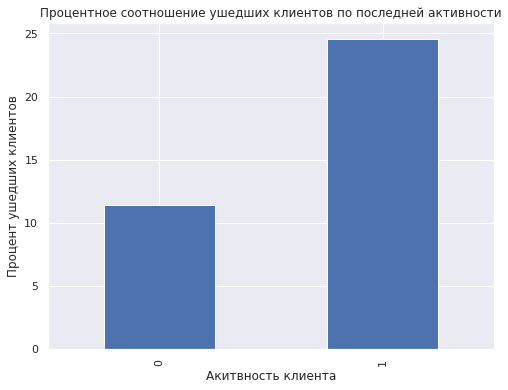

In [68]:
# Рассчитаем процентное соотношение ушедших клиентов по последней активности

data_last_activity_churn = data.pivot_table (index = 'last_activity', values = 'churn', aggfunc = ['sum', 'count'])
data_last_activity_churn.columns = data_last_activity_churn.columns.droplevel(level=1)
data_last_activity_churn ['percent'] = round(data_last_activity_churn['sum']/data_last_activity_churn['count']*100, 2)

data_last_activity_churn['percent'].plot(
    kind='bar', title = 'Процентное соотношение ушедших клиентов по последней активности', figsize = (8,6),
    xlabel = 'Акитвность клиента', ylabel = 'Процент ушедших клиентов');

data_last_activity_churn.sort_values(by='percent', ascending=False)

Клиенты, совершавшие некоторую активность в последнее время уходят чаще неактивных клиентов.

,sum,count,percent
credit_card,,,
0,815,3175,25.67
1,1003,6748,14.86


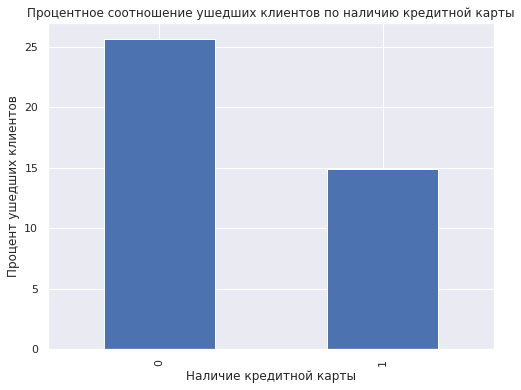

In [69]:
# Рассчитаем процентное соотношение ушедших клиентов по наличию кредитной карты

data_credit_card_churn = data.pivot_table (index = 'credit_card', values = 'churn', aggfunc = ['sum', 'count'])
data_credit_card_churn.columns = data_credit_card_churn.columns.droplevel(level=1)
data_credit_card_churn ['percent'] = round(data_credit_card_churn['sum']/data_credit_card_churn['count']*100, 2)

data_credit_card_churn['percent'].plot(
    kind='bar', title = 'Процентное соотношение ушедших клиентов по наличию кредитной карты', figsize = (8,6),
    xlabel = 'Наличие кредитной карты', ylabel = 'Процент ушедших клиентов');

data_credit_card_churn.sort_values(by='percent', ascending=False)

Видим, что при отсутствии кредитной карты процент ушедших клиентов почти в два раза больше, чем при ее наличии.

,sum,count,percent
products,,,
4,300,474,63.29
5,8,19,42.11
3,297,1029,28.86
2,978,5095,19.20
1,235,3306,7.11


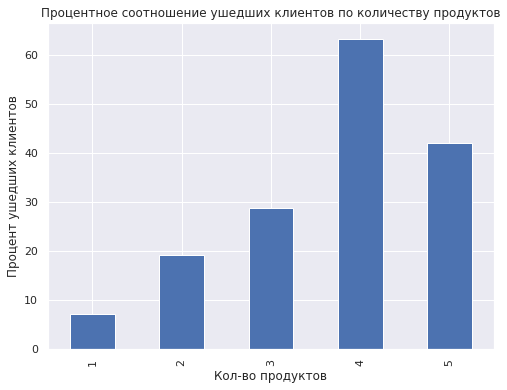

In [70]:
# Рассчитаем процентное соотношение ушедших клиентов по количеству продуктов, которыми пользуется клиент

data_products_churn = data.pivot_table (index = 'products', values = 'churn', aggfunc = ['sum', 'count'])
data_products_churn.columns = data_products_churn.columns.droplevel(level=1)
data_products_churn ['percent'] = round(data_products_churn['sum']/data_products_churn['count']*100, 2)

data_products_churn['percent'].plot(
    kind='bar', title = 'Процентное соотношение ушедших клиентов по количеству продуктов', figsize = (8,6),
    xlabel = 'Кол-во продуктов', ylabel = 'Процент ушедших клиентов');

data_products_churn.sort_values(by='percent', ascending=False)

Больше вссего уходят клиенты, имеющие 4 продукта.

,equity,sum,count,percent
9,9,7,13,53.85
7,7,37,79,46.84
6,6,58,161,36.02
8,8,6,17,35.29
5,5,576,1910,30.16
4,4,464,1841,25.20
3,3,321,1531,20.97
2,2,166,1046,15.87
1,1,93,771,12.06
0,0,90,2554,3.52


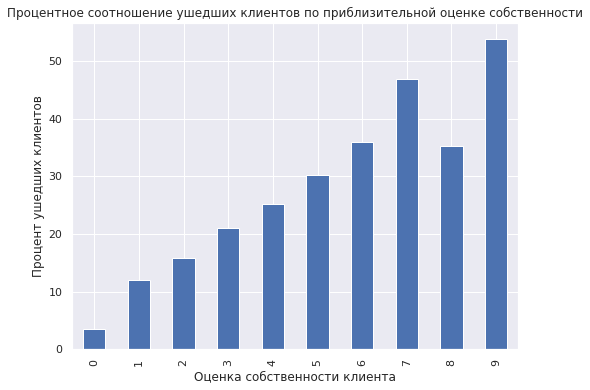

In [71]:
# Рассчитаем процентное соотношение ушедших клиентов по приблизительной оценке собственности клиента

data_equity_churn = data.pivot_table (index = 'equity', values = 'churn', aggfunc = ['sum', 'count']).reset_index()
data_equity_churn.columns = data_equity_churn.columns.droplevel(level=1)
data_equity_churn ['percent'] = round(data_equity_churn['sum']/data_equity_churn['count']*100, 2)

data_equity_churn['percent'].plot(
    kind='bar', title = 'Процентное соотношение ушедших клиентов по приблизительной оценке собственности', figsize = (8,6),
    xlabel = 'Оценка собственности клиента', ylabel = 'Процент ушедших клиентов');

data_equity_churn.sort_values(by='percent', ascending=False)

Видим, что при росте оценки собственности растет и процент ушедших клиентов.

,sum,count,percent
score_group,,,
850-950,1073,4658,23.04
750-850,671,4172,16.08
+950,55,410,13.41
650-750,19,668,2.84
0-650,0,15,0.00


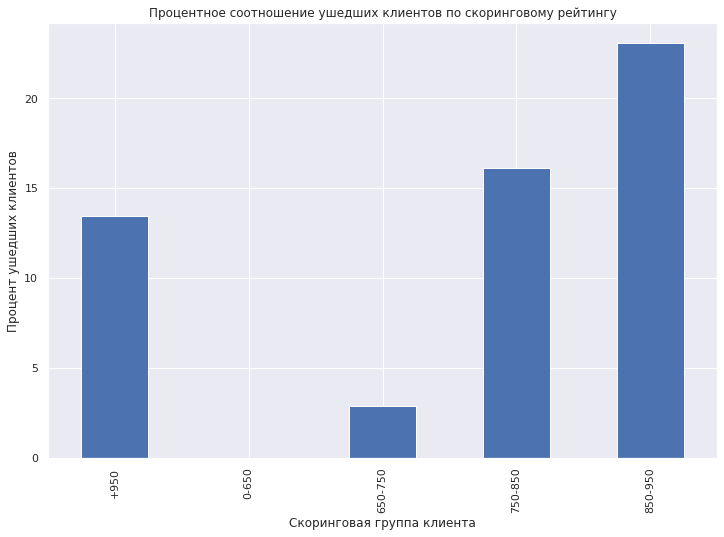

In [72]:
# Рассчитаем процентное соотношение ушедших клиентов по скоринговому рейтингу
data_score_churn = data.pivot_table (index = 'score_group', values = 'churn', aggfunc = ['sum', 'count'])
data_score_churn.columns = data_score_churn.columns.droplevel(level=1)
data_score_churn ['percent'] = round(data_score_churn['sum']/data_score_churn['count']*100, 2)
data_score_churn['percent'].plot(
    kind='bar', title = 'Процентное соотношение ушедших клиентов по скоринговому рейтингу', figsize = (12,8),
    xlabel = 'Скоринговая группа клиента', ylabel = 'Процент ушедших клиентов');

data_score_churn.sort_values(by='percent', ascending=False).head(10)


<hr style="border: 2px solid orange;" />

Видим, что самая большая группа это клиенты с рейтингом от 850 до 950. Далее 750-850. То есть уходят клиенты с большим скоринговым рейтингом.

,sum,count,percent
age_group,,,
50-60,468,1764,26.53
26-35,634,2901,21.85
18-25,62,375,16.53
36-49,588,3859,15.24
60+,66,1024,6.45


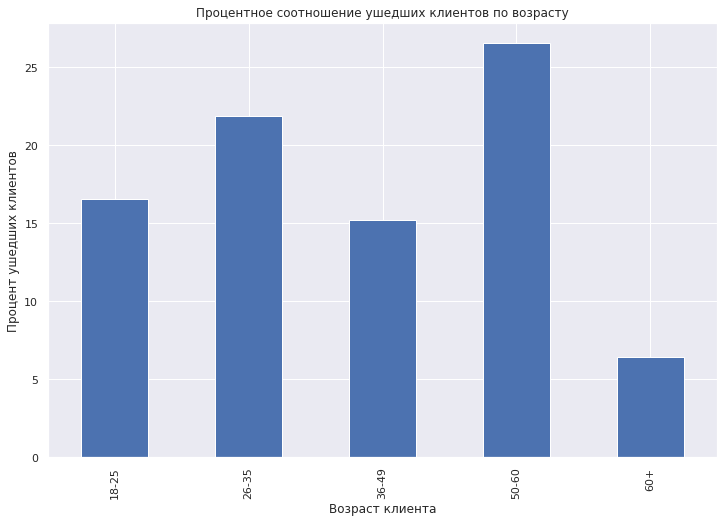

In [ ]:
# Рассчитаем процентное соотношение ушедших клиентов по возрасту

data_age_churn = data.pivot_table (index = 'age_group', values = 'churn', aggfunc = ['sum', 'count'])
data_age_churn.columns = data_age_churn.columns.droplevel(level=1)
data_age_churn ['percent'] = round(data_age_churn['sum']/data_age_churn['count']*100, 2)
data_age_churn['percent'].plot(
    kind='bar', title = 'Процентное соотношение ушедших клиентов по возрасту', figsize = (12,8),
    xlabel = 'Возраст клиента', ylabel = 'Процент ушедших клиентов');

data_age_churn.sort_values(by='percent', ascending=False).head(10)

Самый большой процент ушедших клиентов приходится на группу 50-60 лет, на втором месте группа 26-35 лет.

### Статистический анализ данных.

**Проверка гипотезы различия возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.**

Для данной проверки будем исользовать ttest. Но перед этим неоходимо проверить распределение выборки. Для этого построим гистограмму для столбца "возраст".

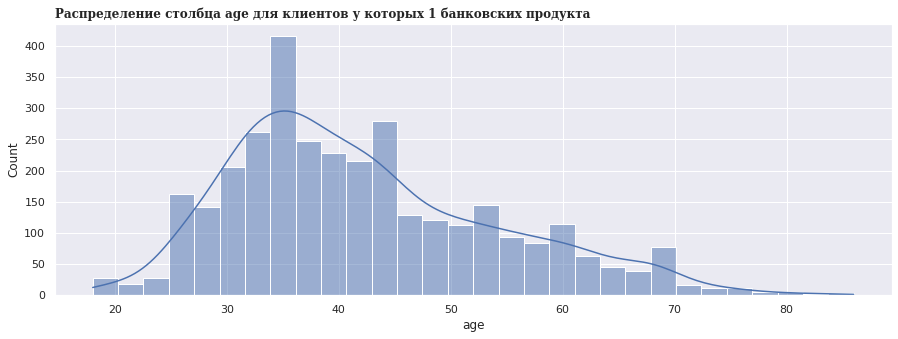

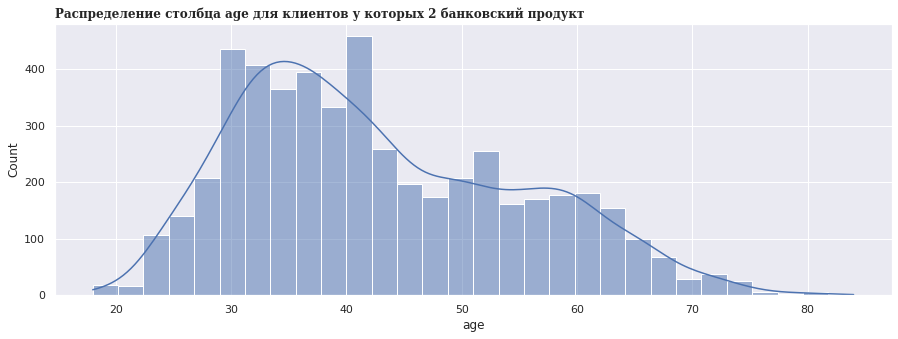

In [76]:
plt.figure(figsize = (15, 5))
sns.histplot(x=data.query('products == 1')['age'], kde=True)
plt.title('Распределение столбца age для клиентов у которых 1 банковских продукта', 
          fontdict= {'fontsize': 12, 'fontweight':'bold', 
                     'fontfamily':'serif'}, loc = 'left')
plt.show()

plt.figure(figsize = (15, 5))
sns.histplot(x=data.query('products == 2')['age'], kde=True)
plt.title('Распределение столбца age для клиентов у которых 2 банковский продукт', 
          fontdict= {'fontsize': 12, 'fontweight':'bold', 
                     'fontfamily':'serif'}, loc = 'left')
plt.show()

Распределение стремиться к нормальному, но не совсем нормальное. Предлагаю сделать 2 теста, один ttest и mann - whitneyu.

**Нуливая гипотеза:** различия в возрасте между клиентами которые пользуются двумя продуктами банка и теми, которые пользуются одним есть.

**Альтернативная гипотеза:** различий в возрасте между клиентами которые пользуются двумя продуктами банка и теми, которые пользуются одним нет.

alpha = 0.05

In [77]:
#ttest
products_1_age = data.query('products == 1')['age']
products_2_age = data.query('products == 2')['age']

alpha = 0.05/2

results = st.ttest_ind(
    products_1_age, 
    products_2_age, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.04054523646600757
Не получилось отвергнуть нулевую гипотезу


**Вывод исходя из данного теста:**  Не получилось отвергнуть нулевую гипотезу, а это значит что различии в возрасте между клиентами которые пользуется двумя продуктами и теми кто пользуется одним есть.

In [78]:
#Манн-Уитни
alpha = 0.05
results = st.mannwhitneyu(products_1_age,  products_2_age)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  0.07199156599101543
Не получилось отвергнуть нулевую гипотезу


**Вывод исходя из данного теста:** Здесь же наоборот, нулевую гипотезу отвергнуть не получилось, а это значит что разница есть.


**Проверка гипотезы различия в количестве используемых банковских продуктов**

Нулевая гипотеза: среднее количество используемых банковских продуктов оставшихся и отточных клиентов равны

Альтернативная гипотеза: среднее количество используемых банковских продуктов оставшихся и отточных клиентов не равны

alpha = 0.05

В этом случае предлагаю так же использовать тест Манна-Уитни, он не требует дополнительных проверок на распредление выборочного среднего.

In [79]:
products_1_churn = data.query('churn == 1')['products']
products_0_churn = data.query('churn == 0')['products']

In [80]:
#Манн-Уитни
alpha = 0.05/2
results = st.mannwhitneyu(products_1_churn,  products_0_churn)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  7.674130300677304e-162
Отвергаем нулевую гипотезу


**Вывод:** И здесь отвергаем теорию о том что среднее количество используемых банковских продуктов оставшихся и отточных клиентов равны.

### Промежуточный итог о том, какие показатели стратегически влияют на отток.

Мы провели исследовательский анализ данных:

* Исследовали распределения признаков.

Возраст: большая часть клиентов в возрастной группе от 36 до 49 лет. Саммые отточные группы по возрасту это: от 26 до 35 лет и от 50 до 60 лет.

Баллы кредитного скоринга: большая часть клиентов имеет от 780 до 920 баллов кредитного скоринга, при этом большая часть клиентов уходит в диапазоне от 825 до 900 баллов.

Пол: в наших данных примерно поровну мужчин и женщин. Мужчины уходят из банка в два раза чаще чем женщины.

Город: большая часть клиентов сосредоточена в Ярославле. В Ярославле клиентыв уходят чаще, чем остаются, в Рыбинске наоборот, большая часть клиентов остается в банке, а в Ростове показатели примерно одинаковы.

Оценка собственности : Большая часть клиентов багка имеет нулевую оценку собственности, на втором и третьем месте идут оценки в 4 и 5 баллов соответственно. Мы заметили явный рост оттока клиентов, начиная с оценки собственности в три балла и более, а с пяти баллов плотность отточных клиентов начинает превышать плотность остающихся.

Балланс на счете: Большая часть клиентов емеет на своем счете от 220 000 у.е. до 440 000 у.е. Клиенты со счетом от 700 000 у.е и более уходят из банка охотнее, чем остаются, а вот клиенты с небольшим счетом наоборот, в основном остаются.

Продукты: У большинства клиентов банка 1-2 продукта. При этом мы видим, что чем больше продуктов у клиентов, тем больше плотность оттока.

Кредитная карта: клиентов с кредитной картой примерно в два раза больше, чем клиентов без нее. Клиенты без кредитной карты уходят чаще чем остаются, а клиенты с кредитной картой наоборот, уходят реже.

Активность клиентов: Активных клиентов ненамного больше чем неактивных. Клиенты, что были активны в последнее время уходили активнее неактивных клиентов.

Заработная плата: Медианная оценочная заработная плата клиента примерно равна 190 000 у.е., в целом, основная часть клиентов имеет зарплаты от 75 000 у.е до 175 000 у.е. Начиная от зарплаты в 100 000 у.е. и более, все больше клиентов уходят из банка.

* Портрет отточных клиентов.

Мы составили общий портрет отточных клиентов, отобразили в нем самые отточные диапазоны всех показателей.

* score — баллы кредитного скоринга: в диапазоне от 800 и более
* city — город: Ярославль
* gender — пол: мужской
* age_group — возрастная группа: 50-60
* equity — приблизительная оценка собственности клиента: 5 и более
* balance — баланс на счёте: 700 000 у.е. и более
* products — количество продуктов, которыми пользуется клиент: от 3 продуктов
* credit_card — есть ли кредитная карта: нет
* last_activity — был ли клиент активен последнее время: да
* est_salary — оценочная заработная плата клиента: от 100 000 у.е.

* Корреляционный анализ.

По корреляционной таблице можем увидеть, что параметр churn имеет зависимость от таких параметров: пол (М, Ж), last_activity (был ли клиент активен последнее время), products (количество продуктов, которыми пользуется клиент), equity (приблизительная оценка собственности клиента), score (баллы кредитного скоринга), age (возраст клиента). Как мы замечали ранее, мужчины уходят в два раза чаще женщин. Клиенты, совершавшие некоторую активность в последнее время уходят чаще неактивных клиентов. Больше вссего уходят клиенты, имеющие 4 продукта. При росте оценки собственности растет и процент ушедших клиентов. Активно клиенты начинают уходить с 800 баллов рейтинга. С 850 до 880 явный рост ухода, а самый яркий пик по графику находится пр рейтинге в 987 баллов. Самый большой процент ушедших клиентов приходится на группу 50-60 лет, на втором месте группа 26-35 лет.

* Статистический анализ данных.

Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались. с большой долей вероятности доходы оставшихся и отточных клиентов не имеют статистически значимых отличий.
Проверка гипотезы различия в количестве используемых банковских продуктов между теми клиентами, которые ушли и теми, которые остались. Нулевая гипотеза об отсутствии различий в количестве используемых банковских продуктов, должна быть отвергнута, это подтверждается проведенным ранее исследовательским анализом.
Проверка гипотезы различия баланса на счете между теми клиентами, которые ушли и теми, которые остались. с большой долей вероятности балансы на счете оставшихся и отточных клиентов не имеют статистически значимых отличий.

### Сегментация пользователей на основе стратегических показателей.

По итогам исследовательского анализа и проверки гипотез выделим несколько высокоотточных сегментов пользователей.

Выберем следующие параметры:

* пол
* возраст
* оценка объектов собственности
* количество используемых продуктов
* был ли клиент активен последнее время
* есть ли кредитная карт
* баллы кредитного скоринга

In [81]:
# Создадим функцию, которая посчитает за нас долю отточных пользователей в сегменте
def segmentation(segment_one, segment_one_churn):
    # Рассчитаем общее число пользователей в этом сегменте:
    result_1 = 'Общее число пользователей в сегменте:', segment_one['user_id'].count()
    # Рассчитаем число отточных пользователей в этом сегменте:
    result_2 = 'Число отточных пользователей в сегменте:', segment_one_churn['user_id'].count()
    #  Рассчитаем долю отточных пользователей:
    result_3 = 'Доля отточных пользователей в сегменте:', round(
        segment_one_churn['user_id'].count() / segment_one['user_id'].count()*100, 2)
    
    #Посмотрим на распределение клиентов относительно того, ушли они из банка или нет
    segment_one['churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8,6))
    plt.legend(['Остался с банком', 'Ушёл из банка'])
    plt.title('Распределение клиентов в сегменте')
    plt.tight_layout()
    
    return result_1, result_2, result_3
    

Сегмент № 1

* (gender) Пол: любой
* (age_group) Возраст: любой
* (city) Город: любой
* (equity) Оценка объектов собственности: 5 и выше
* (score) Скоринговый рейтинг: любой
* (products) Количество используемых продуктов: 3 и больше
* (credit_card) Наличие кредитной карты: не имеет значения
* (last_activity) Пользовательская активность: не имеет значения
* (balance) Баланс на счёте: любой
* (est_salary) Оценочная заработная плата клиента: любая.

(('Общее число пользователей в сегменте:', 543),
 ('Число отточных пользователей в сегменте:', 265),
 ('Доля отточных пользователей в сегменте:', 48.8))

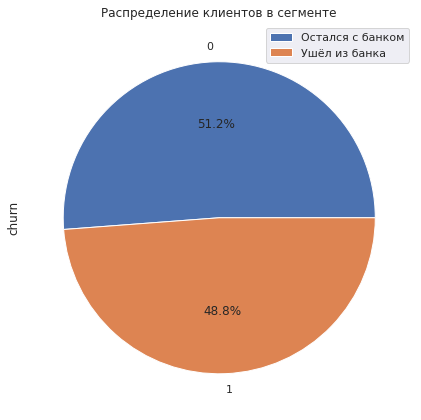

In [82]:
segment_1 = data.query('equity>=5  and products>=3')

segment_1_churn = data.query('equity>=5  and products>=3 and churn==1')

segmentation(segment_1, segment_1_churn)

Сегмент № 2

* (gender) Пол: любой
* (age_group) Возраст: любой
* (city) Город: любой
* (equity) Оценка объектов собственности: 5 и более
* (score) Скоринговый рейтинг: любой
* (products) Количество используемых продуктов: любое
* (credit_card) Наличие кредитной карты: нет
* (last_activity) Пользовательская активность: да
* (balance) Баланс на счёте: любой
* (est_salary) Оценочная заработная плата клиента: любая.

(('Общее число пользователей в сегменте:', 516),
 ('Число отточных пользователей в сегменте:', 241),
 ('Доля отточных пользователей в сегменте:', 46.71))

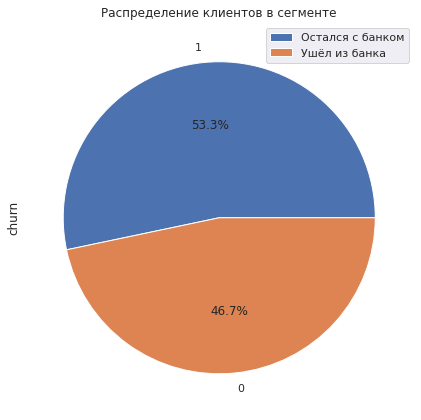

In [83]:
segment_2 = data.query('credit_card==0 and last_activity==1 and equity>=5')

segment_2_churn = data.query('credit_card==0 and last_activity==1 and equity>=5 and churn==0')

segmentation(segment_2, segment_2_churn)

Сегмент № 3

* (gender) Пол: любой
* (age_group) Возраст: 50-60
* (city) Город: любой
* (equity) Оценка объектов собственности: любая
* (score) Скоринговый рейтинг: от 800 баллов
* (products) Количество используемых продуктов: любое
* (credit_card) Наличие кредитной карты: не имеет значения
* (last_activity) Пользовательская активность: да
* (balance) Баланс на счёте: любой
* (est_salary) Оценочная заработная плата клиента: любая.

(('Общее число пользователей в сегменте:', 704),
 ('Число отточных пользователей в сегменте:', 276),
 ('Доля отточных пользователей в сегменте:', 39.2))

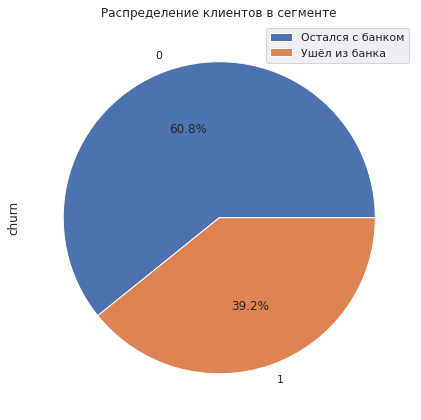

In [84]:
segment_3 = data.query('age_group=="50-60" and last_activity==1 and score>=800')

segment_3_churn = data.query('age_group=="50-60" and last_activity==1 and score>=800 and churn==1')

segmentation(segment_3, segment_3_churn)

Мы рассмотрели несколько сегментов пользователей, выявили процент оттока клиентов в каждом сегменте. Расположим наши сегменты в порядке убывания процента оттока.

* Сегмент № 1 (48,8%)
* Сегмент № 2 (46,7%)
* Сегмент № 3 (39,2%)

### Итоговые выводы и рекомендации для заказчиков.

Проведенный анализ показал, что между оттоком клиентов и некоторыми параметрами существует устойчивая зависимость, а другие параметры практически не влияют на отток.

К параметрам, влияющим на отток, относятся:

* (equity) оценка объектов собственности клиента: чем выше оценка собственности, тем больше доля отточных клиентов;
* (score) скоринговый рейтинг клиента: из банка более высокий процент отток показывали клиенты со скоринговым баллом больше 800;
* (products) количество продуктов, которыми пользуется клиент: клиенты, использовавшие 4 продукта, уходили из банка намного чаще, чем другие;
* (credit_card) наличие кредитной карты: отсутствие у клиента кредитной карты сильно увеличивало риск его оттока из банка;
* (last_activity) активность пользователя: более активные клиенты покидали банк чаще, чем менее активные;
* (gender) пол пользователя: мужчины практически в два раза сильнее склонны уходить из банка, чем женщины;
* (age) возраст пользователя: наиболее отточные возрастные группы - 50-60 и 26-35.
Была проведена проверка следующих гипотез:

**Гипотеза № 1** о различии различия возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним подвердилась.

**Гипотеза № 2** о различия в количестве используемых банковских продуктов так же не подвердилась.

Были выделены и приоритизированы сегменты, в наибольшей степени подверженных оттоку (от 50 до 89% отточных клиентов).

**Рекомендации для отдела маркетинга**

Для улучшения качества обслуживания каждого из выделенных высокоотточных сегментов можно выделить следующие рекомендации:

**Сегмент № 1** (48,8%)

* (gender) Пол: любой
* (age_group) Возраст: любой
* (city) Город: любой
* (equity) Оценка объектов собственности: 5 и выше
* (score) Скоринговый рейтинг: любой
* (products) Количество используемых продуктов: 3 и больше
* (credit_card) Наличие кредитной карты: не имеет значения
* (last_activity) Пользовательская активность: не имеет значения
* (balance) Баланс на счёте: любой
* (est_salary) Оценочная заработная плата клиента: любая. 

Рекомендации: предложить специальные условия по страхованию объектов собственности, можно присылать чуть чаще уведомленя о новых возможностях банка или о действующих сервисах этим клиентам для того, чтобы увеличить их активность и заинтересованность в банке, также это может помочь им увеличить кол-во используемых продуктов банка.

**Сегмент № 2 (46,7%)**

* (gender) Пол: любой
* (age_group) Возраст: любой
* (city) Город: любой
* (equity) Оценка объектов собственности: 5 и более
* (score) Скоринговый рейтинг: любой
* (products) Количество используемых продуктов: любое
* (credit_card) Наличие кредитной карты: нет
* (last_activity) Пользовательская активность: да
* (balance) Баланс на счёте: любой
* (est_salary) Оценочная заработная плата клиента: любая.

Рекомендации: Эти клиенты проявляют некоторую активность, но при этом у них нет кредитной карты, можно предложить им завести кредитную карту, предложить специальные условия по страхованию объектов собственности, присылать чуть чаще уведомленя о новых возможностях банка или о действующих сервисах, для клиентов, получающих зарплату на карту другого банка - предложить льготные условия для перевода зарплаты в наш банк.

**Сегмент № 3 (39,2%)**

* (gender) Пол: любой
* (age_group) Возраст: 50-60
* (city) Город: любой
* (equity) Оценка объектов собственности: любая
* (score) Скоринговый рейтинг: от 800 баллов
* (products) Количество используемых продуктов: любое
* (credit_card) Наличие кредитной карты: не имеет значения
* (last_activity) Пользовательская активность: да
* (balance) Баланс на счёте: любой
* (est_salary) Оценочная заработная плата клиента: любая.

Рекомендации: предложить оформить кредитную карту, если у них ее нет, для клиентов, получающих зарплату на карту другого банка - предложить льготные условия для перевода зарплаты в наш банк, а также предложить им повышенный процент кэшбека на предметы для дома и дачи.